# T-matrix computation for 3D acoustic scattering 

In [3]:
import bempp.api
import numpy as np
import scipy
from numba import objmode
import numba
import math
%matplotlib inline
import matplotlib.pyplot as plt
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
bempp.core.opencl_kernels.set_default_device(0,0)

In [2]:
def normalized_spherical_harmonics(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)

def spherical_bessel_function(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*k*r))*scipy.special.jv(q+0.5, k*r)

def regular_spherical_wavefunctions(p,q,x):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,x)*normalized_spherical_harmonics(p,q,x)

In [3]:
def coeff_sph_expansion(p,q):
    """Analytical formula of the coefficients of the spherical expansions of plane waves"""
    coeff = 4*np.pi*(1j)**q*normalized_spherical_harmonics(-p,q,d)/(-1)**(abs(p))
    return coeff

In [4]:
def sca_far_field(x):
    fun = 0
    i = 0
    for q in range(deg+1):
        for p in range(-q,q+1):
            fun += coeff_sca[i]*(1/k)*(-1j)**(q+1) * normalized_spherical_harmonics(p, q, x)
            i +=1
    return fun

In [5]:
d = [1,0,0] # wave's travel direction
k = 0.4 # wavenumber
eta = k
deg = 5

In [ ]:
error_list = []

for h in [0.1,0.09,0.08,0.07,0.06,0.05]:
    # far field points: unit sphere
    unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
    vert_sphere = unit_sphere.vertices
    space_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

    # scatterer: cube
    dom_cube = bempp.api.shapes.cube(length = 2, origin=(2,-1,-1), h = h)
    vert_cube = dom_cube.vertices
    space_cube = bempp.api.function_space(dom_cube,'P',1)

    identity = bempp.api.operators.boundary.sparse.identity(space_cube, space_cube,space_cube)
    slp = bempp.api.operators.boundary.helmholtz.single_layer(space_cube,space_cube,space_cube,k)
    dlp = bempp.api.operators.boundary.helmholtz.double_layer(space_cube,space_cube,space_cube,k)
    slp_far = helmholtz_farfield.single_layer(space_cube, vert_sphere, k)
    dlp_far = helmholtz_farfield.double_layer(space_cube, vert_sphere,k)

    lhs = 0.5 * identity + dlp - 1j* eta *slp

    slp_far_field_coeff = []
    sph_harm_coeff = []

    for q in range(deg+1):
        for p in range(-q,q+1):
            @bempp.api.complex_callable
            def dirichlet_fun(x,n,domain_index,result):
                    with objmode():
                        result[0] = - regular_spherical_wavefunctions(p,q,x)

            rhs_fun = bempp.api.GridFunction(space_cube, fun = dirichlet_fun)
            field, info = bempp.api.linalg.gmres(lhs, rhs_fun, tol=1E-5)
            slp_far_field_coeff.append(dlp_far.evaluate(field) - 1j * eta * slp_far.evaluate(field))

            @bempp.api.complex_callable
            def sph_harm(x,n,domain_index,result):
                with objmode():
                    result[0] = normalized_spherical_harmonics(p,q,x)
            sph_harm_grid = bempp.api.GridFunction(space_sphere,fun = sph_harm)
            sph_harm_coeff.append(np.conj(sph_harm_grid.coefficients)/((-1j)**(q+1)))

    mass_mat = bempp.api.operators.boundary.sparse.identity(space_sphere,space_sphere,space_sphere).weak_form().A

    T_matrix = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
    for i in range((deg+1)**2):
        for j in range((deg+1)**2):
            T_matrix[i,j] = (slp_far_field_coeff[j] @ mass_mat @ sph_harm_coeff[i])*k

    coeff_inc = []
    for q in range(deg+1):
        for p in range(-q, q+1):
            coeff_inc.append(coeff_sph_expansion(p,q))

    coeff_sca = T_matrix @ coeff_inc

    far_list_test = []
    for i in range(vert_sphere.shape[1]):
        far_list_test.append(sca_far_field(vert_sphere[:,i]))

    @bempp.api.complex_callable
    def exact_data(x, n, domain_index, result):
        result[0] = - np.exp(1j * k * x[0])

    grid_fun = bempp.api.GridFunction(space_cube, fun=exact_data)
    fun_exact, info_exact = bempp.api.linalg.gmres(lhs, grid_fun, tol=1E-5)
    res_exact = dlp_far.evaluate(fun_exact) - 1j * eta * slp_far.evaluate(fun_exact)
    err = np.sqrt((far_list_test - res_exact[0,:]) @ mass_mat @ np.conj(far_list_test - res_exact[0,:]))/np.sqrt(res_exact[0,:]@ mass_mat @ np.conj(res_exact[0,:]))
    error_list.append(err)
    print(h,deg,err)


In [6]:
error_list_2items = []

for h in [0.1,0.09,0.08,0.07,0.06,0.05]:
    # far field points: unit sphere
    unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
    vert_sphere = unit_sphere.vertices
    space_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

    # scatterer: cubes
    cube1 = bempp.api.shapes.cube(length = 2, origin=(-8,-1,-1), h = h)
    cube2 = bempp.api.shapes.cube(length = 2, origin=(2,-1,-1), h = h)
    dom_cube = bempp.api.grid.grid.union([cube1,cube2])

    vert_cube = dom_cube.vertices
    space_cube = bempp.api.function_space(dom_cube,'P',1)

    identity = bempp.api.operators.boundary.sparse.identity(space_cube, space_cube,space_cube)
    slp = bempp.api.operators.boundary.helmholtz.single_layer(space_cube,space_cube,space_cube,k)
    dlp = bempp.api.operators.boundary.helmholtz.double_layer(space_cube,space_cube,space_cube,k)
    slp_far = helmholtz_farfield.single_layer(space_cube, vert_sphere, k)
    dlp_far = helmholtz_farfield.double_layer(space_cube, vert_sphere,k)

    lhs = 0.5 * identity + dlp - 1j* eta *slp

    slp_far_field_coeff = []
    sph_harm_coeff = []

    for q in range(deg+1):
        for p in range(-q,q+1):
            @bempp.api.complex_callable
            def dirichlet_fun(x,n,domain_index,result):
                    with objmode():
                        result[0] = - regular_spherical_wavefunctions(p,q,x)

            rhs_fun = bempp.api.GridFunction(space_cube, fun = dirichlet_fun)
            field, info = bempp.api.linalg.gmres(lhs, rhs_fun, tol=1E-5)
            slp_far_field_coeff.append(dlp_far.evaluate(field) - 1j * eta * slp_far.evaluate(field))

            @bempp.api.complex_callable
            def sph_harm(x,n,domain_index,result):
                with objmode():
                    result[0] = normalized_spherical_harmonics(p,q,x)
            sph_harm_grid = bempp.api.GridFunction(space_sphere,fun = sph_harm)
            sph_harm_coeff.append(np.conj(sph_harm_grid.coefficients)/((-1j)**(q+1)))

    mass_mat = bempp.api.operators.boundary.sparse.identity(space_sphere,space_sphere,space_sphere).weak_form().A

    T_matrix = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
    for i in range((deg+1)**2):
        for j in range((deg+1)**2):
            T_matrix[i,j] = (slp_far_field_coeff[j] @ mass_mat @ sph_harm_coeff[i])*k

    coeff_inc = []
    for q in range(deg+1):
        for p in range(-q, q+1):
            coeff_inc.append(coeff_sph_expansion(p,q))

    coeff_sca = T_matrix @ coeff_inc

    far_list_test = []
    for i in range(vert_sphere.shape[1]):
        far_list_test.append(sca_far_field(vert_sphere[:,i]))

    @bempp.api.complex_callable
    def exact_data(x, n, domain_index, result):
        result[0] = - np.exp(1j * k * x[0])

    grid_fun = bempp.api.GridFunction(space_cube, fun=exact_data)
    fun_exact, info_exact = bempp.api.linalg.gmres(lhs, grid_fun, tol=1E-5)
    res_exact = dlp_far.evaluate(fun_exact) - 1j * eta * slp_far.evaluate(fun_exact)
    err = np.sqrt((far_list_test - res_exact[0,:]) @ mass_mat @ np.conj(far_list_test - res_exact[0,:]))/np.sqrt(res_exact[0,:]@ mass_mat @ np.conj(res_exact[0,:]))
    error_list_2items.append(err)
    print(h,deg,err)

0.1 5 (0.031387424944335184-3.8224860366484123e-19j)
0.09 5 (0.0306942480028073+0j)
0.08 5 (0.03020349958567636-5.880948134144827e-20j)
0.07 5 (0.02970415670882703+4.603389714931466e-19j)
0.06 5 (0.029265613487728253-2.0554417591259696e-22j)
0.05 5 (0.028942942015575138-3.5900553985961272e-22j)


In [8]:
dom_cube = bempp.api.shapes.cube(length = 2, origin=(2,-1,-1), h = 0.1)

In [9]:
bempp.api.export('cube.msh',grid = dom_cube)

In [1]:
test_list_1cube = [0.0024261398858258145,0.0019030772254768806,0.0015271490949518949,0.001153365807478154,0.0008222656671002751,0.0005861053327622432]

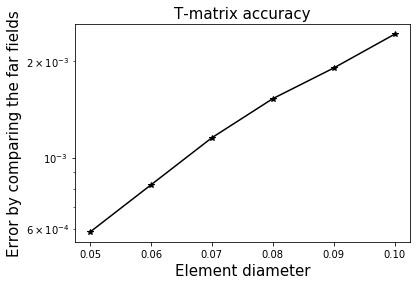

In [6]:
x_axis = [0.1,0.09,0.08,0.07,0.06,0.05]
#fig = plt.figure()
#ax.set_ylim(0.0004,0.001)
plt.semilogy(x_axis,test_list_1cube,'k-*')

plt.xlabel('Element diameter',fontsize = 15)
plt.ylabel('Error by comparing the far fields',fontsize = 15)
plt.title('T-matrix accuracy',fontsize = 15)
plt.savefig('Converge by refining the grid-Cube deg5.pdf',bbox_inches='tight')

In [ ]:
x_axis = np.linspace(0.03,0.1, num=8)
y_axis = error_list2
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim(0.0005,0.007)
plt.semilogy(x_axis,y_axis)
for i,j in zip(x_axis,y_axis):
    ax.annotate(str(j),xy=(i,j))
plt.xlabel('Size of the elements on the mesh-Cube')
plt.ylabel('Error by comparing the far fields' )
plt.savefig('Converge by refining the grid-Cube.pdf')